## Convolutional Neural Network (CNN) applied to Radiology (Pneumonia)
***
Neural Networks are computing models based on the structures neuron cells form, for example, in our brain tissue. Each of them are manly comprised of a high number of interconnected computational nodes (also colled 'neuron') of which work entwine in a distributed fashion to collectivlely learn from the input in order to optimise its final output.  
Thanks to their flexiblity and efficiency, Neural Networks are used broadly in classification problems such as sentient analysis or image classification. In this notebook, we`ll use a Convolutional Neural Network which is amazing for image classification problems thanks to the 2D convolution which applies filters and a kernel to learn and evaluate images.

### Importing the required libraries
For our CNN we will manly use the Tensorflow framework, numpy and matplotlib for visualizing how our model did during training.

In [75]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

### Preliminary actions
Before jumping straight into training and creating our model, we need to decide at what size do we want to rescale our images and check for class imbalance.  
  
Here`s the topology of our folders:  
chest_xray ->  train ->  NORMAL | PNEUMONIA  
  
Since we have two already made folders for the different classes, we can simply count how many images we have in each folder and see if our data is balanced or not. For our case we have a big imbalace between the two classes and we need to take action, otherwise our model won't train correctly and will be biased towards the class with more data.

In [76]:
img_size = [160, 160]

# Creating the dataset
# Before loading up our dataset, lets count how many training photo of each class we have
train_dir = './chest_xray/train/'

# Before starting the creation of the dataset, we need to make sure we have a equal number of
# training data for both classes. 
normal_count = 0

for path in os.listdir(train_dir+'NORMAL'):
    if os.path.isfile(os.path.join(train_dir+'NORMAL', path)):
        normal_count += 1

pneumonia_count = 0

for path in os.listdir(train_dir+'PNEUMONIA'):
    if os.path.isfile(os.path.join(train_dir+'PNEUMONIA', path)):
        pneumonia_count += 1

print('Normal: ' + str(normal_count) + ' Pneumonia: ' + str(pneumonia_count))

Normal: 1341 Pneumonia: 3875


### Creating the datasets
As we said before, our data is already divided by label and class. This simplify the process of creating the dataset because we don't need to divide the data manually. For our datasets we will use a batch size of 128, along with an image size of 160x160 and we will make use of the 'shuffle' functionality which helps to diversify our batches. 
  
The batch size indicates of many images we will give to our CNN before the model is updated, in this case we will use the **mini** sized batch of 128.  
   
Regarind the image size, we need to rescale every single image. This helps our dataset become more normalized and we won't have any inconsistency  between our images, making the training actually doable and faster.

In [77]:
# Creating the datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    batch_size=128,
    image_size=img_size,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'chest_xray/test',
    labels='inferred',
    batch_size=128,
    image_size=img_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    'chest_xray/val',
    labels='inferred',
    batch_size=128,
    image_size=img_size,
    shuffle=True
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


### Adjusting weights to combat class unbalance
We saw that we have a big class imbalance with PNEUMONIA images having almost 3x the numbers of NORMAL images. To correct this we can apply different tecniques:  
1. Data Augmentation
2. Adjusting Class Weights

For this case, we will calculate the correct class weights to make classification more unbiased. We can do that by doing a simple calculation using the numbers of image per class and the total number of images. 
  
As we can see, we get almost a 2.0 class weight for NORMAL class and a 0.67 for the PNEUMONIA class. This means that the model give a larger rewards/penalty for any image correctly/falsy classified as NORMAL, thus balacing the dataset.

In [78]:
weight_normal = (1 / normal_count)*(5216)/2.0 
weight_pneumonia = (1 / pneumonia_count)*(5216)/2.0

class_weights = {0: weight_normal, 1: weight_pneumonia}
class_names = train_dataset.class_names
print(class_names)
print(weight_normal, weight_pneumonia)

['NORMAL', 'PNEUMONIA']
1.9448173005219984 0.6730322580645162


### Preparing the training datasets
To ensure we don't risk blocking the I/O from disk, we'll use the methods cache() and prefetch().  
  
Cache(): keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model.  
  
Prefetch(): overlaps data preprocessing and model execution while training.

In [79]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating the architecture of our CNN
For the first layer of our CNN we'll need to rescale our image and indicate the input dimension. Since our image's rgb channels have values between [0,255] we need to rescale those numbers to a range of [0.0,1.0], thus making it ideal for the training of our CNN.  
  
Up first we have 6 convolution layers interconnected by 3 Pooling layer. We'll use the activation function 'relu' and diminishing filters as we get to the inner convolution layers. After every pair of convolution layers we have a Pooling layer which helps reduce spatial dimensionality basically downsampling our images.  
  
The Max pooling layer takes the maximum value from the kernel matrix. It is like paying attentions to details on the image recognizing patterns and features.  
  
After the convolution part is done, we have a Dropout layers; these layers, as their name implies, drop some of the training data thus reducing the risk of overfitting.  
  
Finally, we get to the interconneted dense layers. Before continuing we need to 'Flatten' our dimension to a single channel so our neurons can compute the weights and continue training.  
  
Regardin the metrics, we'll use: Precison, Recall, Accuracy.

In [80]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compiling the model
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=METRICS
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 160, 160, 128)     3584      
                                                                 
 conv2d_50 (Conv2D)          (None, 160, 160, 128)     147584    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 80, 80, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 80, 80, 64)        73792     
                                                                 
 conv2d_52 (Conv2D)          (None, 80, 80, 64)        36928     
                                                      

### Finally, training the CNN
For our training we will use the EarlyStopping() method. This helps to stop training if the designated metric is no longer improving, in this case we'll use the default which is 'val_loss'.

In [81]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=18,restore_best_weights=True) 

# Training the model
epochs = 30
history = model.fit(
    train_dataset, 
    epochs=epochs,
    validation_data=val_dataset,
    class_weight=class_weights,   
    callbacks=[early_stop]
)

Epoch 1/30
41/41 [==============================] - 25s 520ms/step - loss: 0.6919 - accuracy: 0.4183 - precision: 0.7529 - recall: 0.3231 - val_loss: 0.6916 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 2/30
41/41 [==============================] - 21s 514ms/step - loss: 0.6911 - accuracy: 0.4620 - precision: 0.7695 - recall: 0.3938 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7500
Epoch 3/30
41/41 [==============================] - 21s 511ms/step - loss: 0.6898 - accuracy: 0.4812 - precision: 0.7839 - recall: 0.4165 - val_loss: 0.6886 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7500
Epoch 4/30
41/41 [==============================] - 21s 512ms/step - loss: 0.6884 - accuracy: 0.4843 - precision: 0.7836 - recall: 0.4225 - val_loss: 0.6859 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 5/30
41/41 [==============================] - 21s 515ms/step - loss: 0.6845 - accuracy: 0.5188

### Visualizing our model accuracy and loss


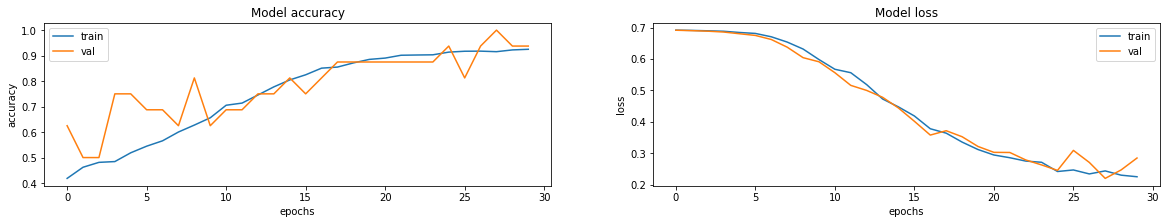

In [82]:
# Visualizing our model accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

### Evaluating our model

After the training phase, now it's time to see how our model is doing using the test data. Since we are talking about medicine, we have to look for 2 important metrics which are Precision and Recall. This is because, in medicine, it's important to watch out for false positives and that means 'Accuracy' isn't enought when evaluating our model.  
  
Precision: The precision is calculated as the ratio between the number of Positive samples correctly classified to the total number of samples classified as Positive  
Recall: The recall measures the model's ability to detect Positive samples  
Accuracy: Accuracy is a metric that generally describes how the model performs across all classes  

In [83]:
test_loss, test_score, test_precision, test_recall = model.evaluate(test_dataset)
print('Loss on test: ' + str(test_loss))
print('Accuracy on test: ' + str(test_score))
print('Precison on test: ' + str(test_precision))
print('Recall on test: ' + str(test_recall))

5/5 [==============================] - 2s 163ms/step - loss: 0.3885 - accuracy: 0.8269 - precision: 0.8039 - recall: 0.9564
Loss on test: 0.3884773552417755
Accuracy on test: 0.8269230723381042
Precison on test: 0.8038793206214905
Recall on test: 0.9564102292060852


Results:  
**Accuracy**: 0.8269  
**Loss**: 0.3885  
**Precision**: 0.8039  
**Recall**: 0.9564  
  
We have a really high Recall which is really good, a decent accuracy and loos and finally a decent precision. Not bad! Unfortunately, when dealing with images and specifically medical data, it`s difficult to get insanely high results, so we need to make compromises as try to find a good balance between our metrics.

### Let's see and example of classification

1/1 [==============================] - 0s 88ms/step
[[0.15138368]]


Text(0.5, 1.0, 'Normal')

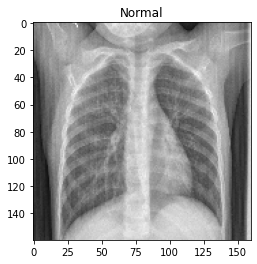

In [84]:
test_image = 'person1_virus_6.jpeg'
test_image_n = 'IM-0009-0001.jpeg'
from keras.preprocessing import image

img = tf.keras.preprocessing.image.load_img(test_image_n, target_size = (160, 160))
img2 = img
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
model_test = model.predict(img)

print(model_test)
plt.imshow(img2)
plt.title('Real class: Normal' + ' | ' + 'Predicted class:' + 'Pneumonia'if model_test > 0.50 else 'Normal')
